# IMDB EDA
Initial exploration of the imdb data with the following goals: 
- What columns exist in the data? 
- How much? 
- How long are the documents? 

### Important notes
- Raw data is in `../data/aclimdb_v1.tar.gz`
- Lit review on preprocessing long data 

In [1]:
from pathlib import Path
from typing import Dict, Union, List
from nltk.tokenize import word_tokenize
import tarfile
import numpy as np
import re
import pandas as pd
import fileinput as fi

DATA_DIR = Path("../data/")

In [2]:
def glob_text_dat(dr: Path) -> List[Path]:
    return list(dr.glob("*.txt"))

def glob_all_reviews(dr: Path) -> List[Path]:
    return glob_text_dat(dr / "pos") + glob_text_dat(dr / "neg")

def read_review(review_path: Path) -> str:
    with open(review_path, "r", encoding="utf8") as f:
        return f.readline()

def review_to_row(line: str, review_path: Path) -> Dict[str, Union[str, int]]:
    review_id = review_path.name[:-4]
    label = 1 if review_path.parent.name == "pos" else 0
    origin = review_path.parent.parent.name
    return {"id": review_id, "origin": origin, "text": line, "label": label}

    
def get_movie_id(movie_url: str) -> str:
    return re.search("tt\d+", movie_url).group()

In [13]:
# Unzipping the data files :)
data_path = next(DATA_DIR.glob("*tar.gz"))

if not (DATA_DIR / "aclimdb").exists():
    with tarfile.open(data_path, 'r:gz') as tar:
        tar.extractall(path = DATA_DIR)
                

## Create useful training data 
Now that they are unzipped, I will put them into a pandas dataframe which is easier to load :))

In [3]:

MAIN_DIR = DATA_DIR / "aclimdb"

test_paths = glob_all_reviews(MAIN_DIR / "test")
train_paths = glob_all_reviews(MAIN_DIR / "train")
all_paths = test_paths + train_paths

In [7]:
i = 0
review_list = [dict.fromkeys(["id", "origin", "text", "label"]) for _ in range(len(all_paths))]
with fi.input(all_paths, openhook=fi.hook_encoded("utf-8")) as f:
    for line in f:
        review_list[i] = review_to_row(line, f.filename())
        i += 1
        if i % 5000 == 0:
            print(f"done processing {i} files")

done processing 5000 files
done processing 10000 files
done processing 15000 files
done processing 20000 files
done processing 25000 files
done processing 30000 files
done processing 35000 files
done processing 40000 files
done processing 45000 files
done processing 50000 files


In [8]:
all_data = pd.DataFrame.from_records(review_list)
all_data.to_csv(DATA_DIR / "all_data.csv")

In [4]:
all_data = pd.read_csv(DATA_DIR / "all_data.csv")

## Splitting into train test
Now I split into test set making sure not to have leakage for movies :))

In [5]:
all_movies = pd.DataFrame(columns = ["movie_id", "source", "linenum"], index = range(len(test_paths)))
with fi.input((MAIN_DIR / "test").glob("*.txt"), openhook=fi.hook_encoded("utf-8")) as f:
    for i, line in enumerate(f):
        all_movies.loc[i, "movie_id"] = line
        all_movies.loc[i, "linenum"] = f.filelineno() - 1
        all_movies.loc[i, "source"] = f.filename().name
all_movies["movie_id"] = all_movies["movie_id"].str.extract("tt(\d+)").values
all_movies["source"] = all_movies["source"].str.contains("pos").astype(int)

In [6]:
# Randomly choose N hundred movies
N = 700
unique_movies = all_movies["movie_id"].unique()
np.random.seed(42)
target_movies = np.random.choice(unique_movies, N)

# Create ids
test_movies = all_movies[all_movies["movie_id"].isin(target_movies)]
test_ids = test_movies["source"].astype(str) + "_" + test_movies["linenum"].astype(str)

In [7]:
all_data["test_id"] = all_data["label"].astype(str) + "_" + pd.Series(all_data["id"].str.extract("(\d+)_\d+").values.reshape((-1, )))
all_data.loc[all_data["origin"] == "train", "test_id"]  = None

In [8]:
all_data

,Unnamed: 0,id,origin,text,label,test_id
0,0,0_10,test,I went and saw this movie last night after bei...,1,1_0
1,1,10000_7,test,Actor turned director Bill Paxton follows up h...,1,1_10000
2,2,10001_9,test,As a recreational golfer with some knowledge o...,1,1_10001
3,3,10002_8,test,"I saw this film in a sneak preview, and it is ...",1,1_10002
4,4,10003_8,test,Bill Paxton has taken the true story of the 19...,1,1_10003
...,...,...,...,...,...,...
49995,49995,9998_4,train,"Towards the end of the movie, I felt it was to...",0,None
49996,49996,9999_3,train,This is the kind of movie that my enemies cont...,0,None
49997,49997,999_3,train,I saw 'Descent' last night at the Stockholm Fi...,0,None
49998,49998,99_1,train,Some films that you pick up for a pound turn o...,0,None


In [9]:
test_data = all_data.loc[all_data["test_id"].isin(test_ids), ["id", "text", "label"]]
train_data = all_data.loc[~all_data["test_id"].isin(test_ids), ["id","text", "label"]]
test_data.to_csv(DATA_DIR / "imdb_test.csv")
train_data.to_csv(DATA_DIR / "imdb_train.csv")

In [11]:
test_data

,id,text,label
66,1005_7,In this TV special Jon is the one who needs a ...,1
77,1006_8,[CONTAINS SPOILERS!!!]<br /><br /> Garfield an...,1
88,1007_9,"I am a huge fan of Harald Zwart, and I just kn...",1
99,1008_10,This was one of the few Norwegian movies I act...,1
110,1009_8,I hate football!! I hate football fans! I hate...,1
...,...,...,...
24992,9995_2,many people said this was a great movie with H...,0
24993,9996_2,"This is one dreary, inert, self-important bore...",0
24994,9997_2,"Awful, awful, awful times a hundred still does...",0
24995,9998_1,I occasionally let my kids watch this garbage ...,0


## Checking data quality

longest review is 2470 words
docs too long for BERT: 3694
docs too long for Longformer: 0


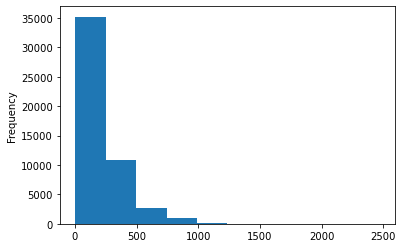

In [69]:
def get_num_tokens(text_series: pd.Series) -> pd.Series:
    return text_series.str.split().apply(len)


def rows_longer_than(text_series: pd.Series, cutoff=int) -> int:
    return (get_num_tokens(text_series) > cutoff).sum()

# Review length
token_length = get_num_tokens(all_data["text"])
token_length.plot.hist()
print(f"longest review is {token_length.max()} words")
print(f"docs too long for BERT: {(token_length > 512).sum()}")
print(f"docs too long for Longformer: {(token_length > 4096).sum()}")



## Length notes
It seems that most reviews are relatively short with a few quite long ones. It seems, however, that a longformer should be able to deal with them rather nicely, if the token mappings are approximately right. 